## This notebook:

  * Converts the S- and C-band measured flux densities to $L_{1.4GHz}$
  
  
  
  
  * Takes the computed L1.4 to compute SFRs for both Amy and Gordon's samples using equation 13 from Yun et al. 2001
    * $$ SFR [M_{sun}/yr] = (5.9±1.8) * 10^{-22}L_{1.4GHz}[W/Hz] $$
  
  
  
  
  
  * Uses DR7 magnitudes $M_i(z=2)$ to compute SFR from equation 2 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = -(29±16)M_i^2 - (1625±825)M_i - (22505±10244) $$
  
  
  
  
  
  * Uses our ICA CIV EQW ($E_C$) to compute SFR from equation 8 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = (4205±651)E_C^{-0.5} - (328±98) $$
    
    
    
    
    
  * Then use Amy's "forced photometry" method (measuring the NVSS flux density at the optical location of all 8653 sources belonging to our parent sample) to derive mean/median star-formation predictions for our entire color-selected parent sample
  
  
  
  
  * Note that I'm still putting some finishing touches on the imaging, so theses results aren't quite final (at least the ones that use GTR radio data), but I'll re-run everything once our measurements are finalized.  There's also no account for evolution between the two samples yet

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import richardsplot
from astropy.cosmology import FlatLambdaCDM

In [2]:
#Equations
def L14(nu, f, z, LD):
    #Compute 1.4GHz luminosity given flux at nu and apply K-correction
    Lobs = (4*np.pi*LD**2*1e-23*f*1e-6) * 1e-7
    nuobs = nu*(1+z)
    return Lobs * (1.4/nuobs)**(-.7)

def SFR_L14(L14):
    return 5.9e-22 * L14

def SFR_Mi(Mi):
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [3]:
#Use this cosmology - are we OK with this?
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
#Load in GTR data
df = pd.read_csv("SpringFinalFigs_moreParams.csv")
f3 = df[["peak_flux"]].values.flatten() 
ND = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==0
D = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==1
F = (df[["detection"]].values.flatten()+df[["FIRST"]].values.flatten())==2
Mi = df[["MIZ2"]].values.flatten()
eqw = df[["ICA_CIV_EQW"]].values.flatten()
z_gtr = df[["redshift_1"]].values.flatten()
LD_gtr = 3.086e24*cosmo.luminosity_distance(z_gtr).value
L14_gtr = L14(3., f3, z_gtr, LD_gtr)

#Amy's sample
df2 = pd.read_csv("RQQfigs.csv")
f6 = df2[["Flux"]].values.flatten()
det = df2[["Detection"]].values.flatten()==1
z_amy = df2[["z"]].values.flatten()
LD_amy = 3.086e24*cosmo.luminosity_distance(z_amy).value
L14_amy = L14(6., f6, z_amy, LD_amy)

#Kellerman data
df3 = pd.read_csv("KellermanQSOs.csv")
f6kell = df3[["S(6)_t"]].values.flatten()
z_kell = df3[["z"]].values.flatten()
LD_kell = 3.086e24*cosmo.luminosity_distance(z_kell).value
L14_kell = L14(6., f6kell, z_kell, LD_kell)

---

### 1.4GHz Luminosities

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


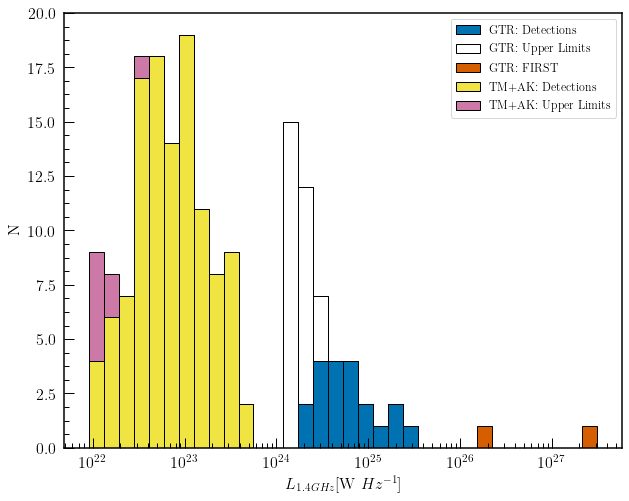

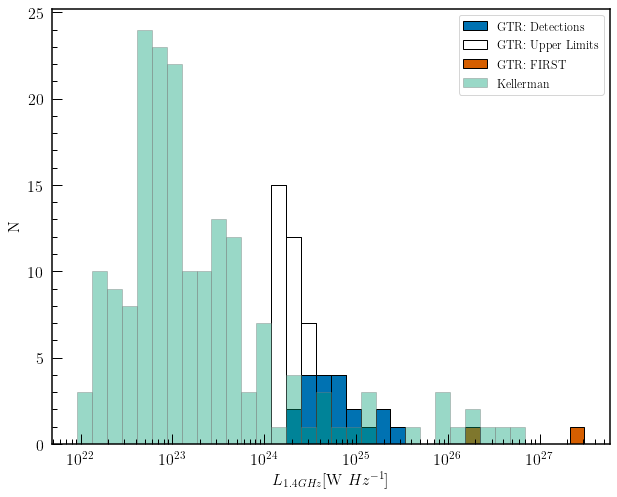

In [5]:
fig = plt.figure(figsize=(10,8))
bins1 = np.logspace(np.log10(min(L14_amy)), np.log10(max(L14_gtr)), 35)

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([L14_amy[det], L14_amy[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"], bins=bins1, 
         edgecolor="k", label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist([L14_kell], histtype="barstacked", color="#009e73", bins=bins1, label=["Kellerman"],
          alpha=0.4, edgecolor="grey")

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.legend(loc="best")
plt.show()

### Yun SFRs

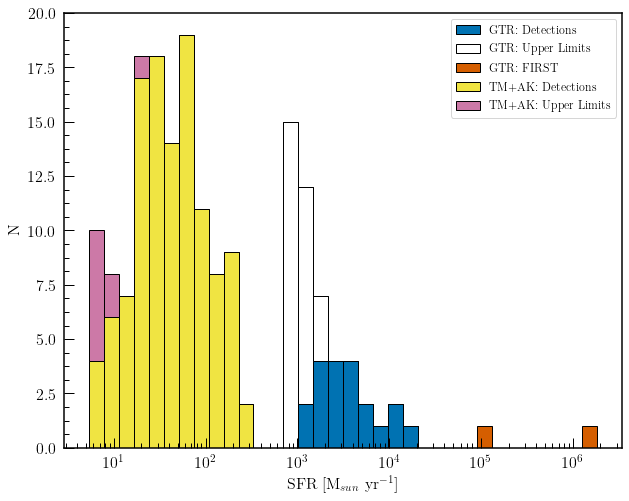

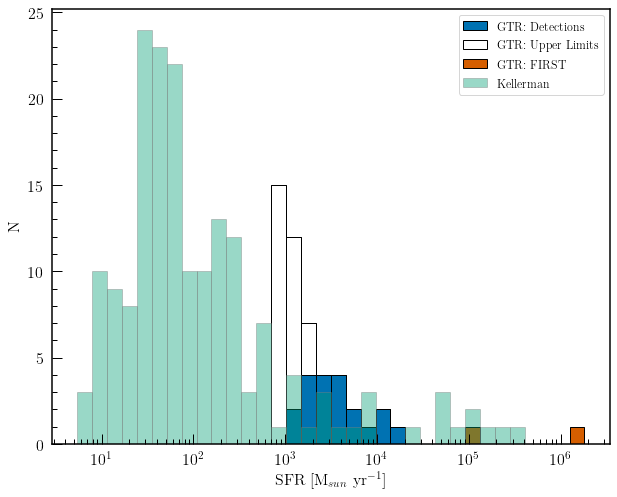

Star formation predictions by Yun et al. 2001:
GTR   median SFR: 1400.89 Msun/yr
AK+TM median SFR: 35.92 Msun/yr
Kell  median SFR: 62.81 Msun/yr


In [6]:
fig = plt.figure(figsize=(10,8))
bins2 = np.logspace(np.log10(min(SFR_L14(L14_amy))), np.log10(max(SFR_L14(L14_gtr))), 35)

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([SFR_L14(L14_amy[det]), SFR_L14(L14_amy[~det])], histtype="barstacked", color=["#f0e442", "#cc79a7"], 
         edgecolor="k", bins=bins2, label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist(SFR_L14(L14_kell), histtype="barstacked", color="#009e73", label="Kellerman",
          alpha=0.4, bins=bins2, edgecolor="grey")

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.legend(loc="best")
plt.show()


print("Star formation predictions by Yun et al. 2001:")
print("GTR   median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_gtr))))
print("AK+TM median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_amy))))
print("Kell  median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_kell))))

---

### Other SF calculations

Star formation predictions by Harris et al. 2016:
GTR median SFR (Mi) : 202.33 Msun/yr
GTR median SFR (EQW): 76.73 Msun/yr


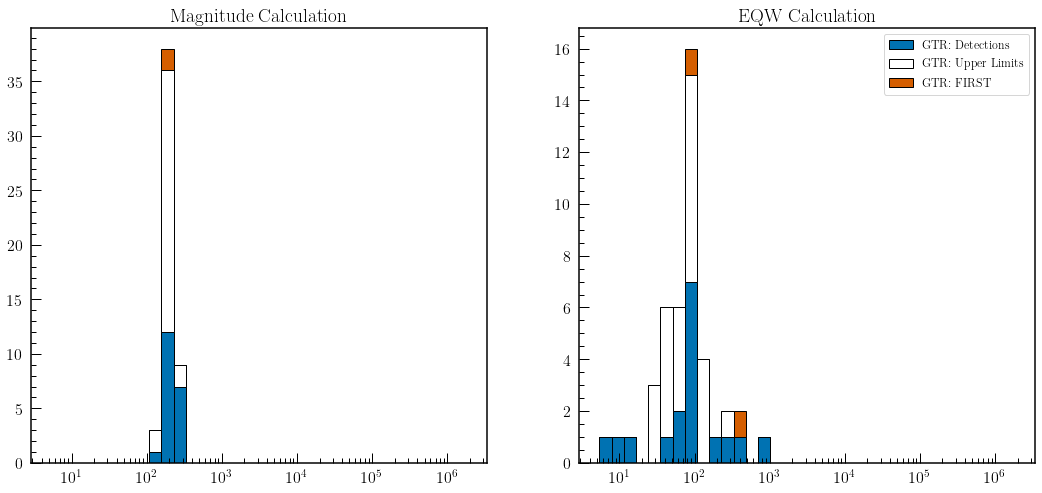

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].hist([SFR_Mi(Mi[D]), SFR_Mi(Mi[ND]), SFR_Mi(Mi[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[0].set_xscale("log")
ax[0].set_title("Magnitude Calculation")

ax[1].hist([SFR_eqw(eqw[D]), SFR_eqw(eqw[ND]), SFR_eqw(eqw[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[1].set_xscale("log")
ax[1].set_title("EQW Calculation")
ax[1].legend(loc="best")

print("Star formation predictions by Harris et al. 2016:")
print("GTR median SFR (Mi) : %.2f Msun/yr" % (np.median(SFR_Mi(Mi))))
print("GTR median SFR (EQW): %.2f Msun/yr" % (np.median(SFR_eqw(eqw))))

Can use these values to re-compute luminosities through SFR predictions:

  $$ L_{1.4}  =  1.7*10^{21} \dot{M}_s $$

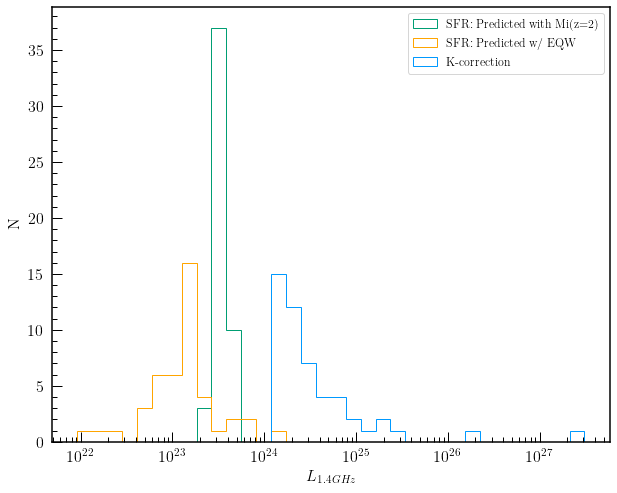

In [8]:
#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw = 1.7e21*SFR_eqw(eqw)
L14_Mi = 1.7e21*SFR_Mi(Mi)

fig = plt.figure(figsize=(10,8))
plt.hist([L14_gtr, L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["#0099ff", "#ffa500", "#009e73"],
          label=["K-correction", "SFR: Predicted w/ EQW", "SFR: Predicted with Mi(z=2)"])
plt.xscale("log")
plt.xlabel("$L_{1.4GHz}$")
plt.ylabel("N")
plt.legend(loc="best")
plt.show()

So, the SFRs calculated with our optical magnitudes seem to roughly agree with the ~300Msol/yr mean SFR derived for z$\sim$2 in Harris+16, but neither equation from that really agrees with Yun et al. 2001 at all.

Per section 6.4 of Yun et al. (preceding equation 13):
"The integrated 1.4 GHz luminosity density derived from the IRAS 2 Jy sample for L1.4GHz<=10^24 W Hz is 2.6 * 10^19 W Hz-1 Mpc-1 (see Fig. 14). The empirical conversion relation that links this 1.4 GHz luminosity density to the local star formation density of 0.015 ^ 0.005 M_sol yr-1 is then [equation 13]"

--> Our targets too luminous in the radio to apply this equation, so it makes sense that the two papers don't really agree with each other.  Equation built around low-redshift QSOs below the expected "knee" of the RLF at 10^24W/Hz(so may actually prove very useful for mine and Amy's sample)

---

### Forced photometry with NVSS on our N=8653 color-selected parent sample; what is the mean/median star formation rate predicted by this?

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Fit Results:
Mean   = 0.1389 mJy/b
Median = 0.1100 mJy/b
Std    = 0.5734 mJy/b


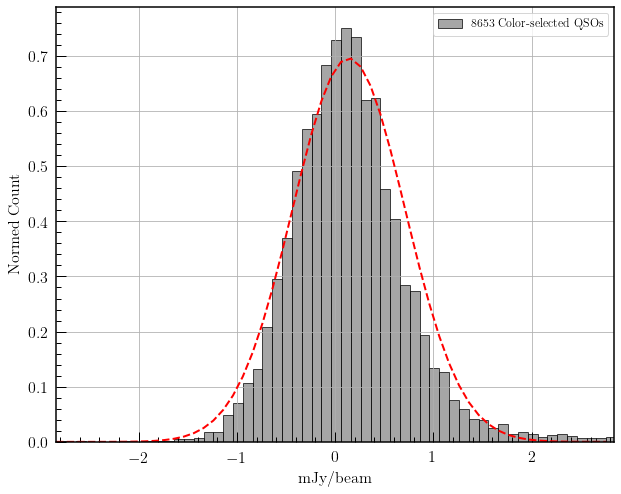

In [9]:
pf = 1e-3*f3 #convert GTR flux from µJy to mJy
pixels = 1000.*(pd.read_csv("forced_photometry.csv").values.flatten()) #values in Jy - want mJy

pixbins=np.arange(min(pixels), max(pixels), .1)

fig = plt.figure(figsize=(10,8))
plt.hist(pixels, color="grey", edgecolor="k", density=True, bins=pixbins, alpha=0.7, label="8653 Color-selected QSOs")
plt.xlim(min(pixels), abs(min(pixels)))
plt.xlabel("mJy/beam")
plt.ylabel("Normed Count")
plt.legend(loc="best")
plt.grid(True)

# best fit of data
(mu, sigma) = norm.fit(pixels[pixels<abs(min(pixels))])
median = np.median(pixels[pixels<abs(min(pixels))])


# add a 'best fit' line
y = mlab.normpdf(pixbins[pixbins<=abs(min(pixels))], mu, sigma)
l = plt.plot(pixbins[pixbins<=abs(min(pixels))], y, 'r--', linewidth=2)

print("Fit Results:")
print("Mean   = %.4f mJy/b" % (mu))
print("Median = %.4f mJy/b" % (median))
print("Std    = %.4f mJy/b" % (sigma))

Note that I only performed the fit on the selected window of data; this distribution actually has a very long tail extending to $\sim$3200mJy/beam and can't be reasonably fit on its own.  Important to also note that these quasars are not all z=1.6, but $1.6 \leq z \leq 2.1$.  In computing mean/median luminosities/SFRs below, I use the midpoint z=1.85 to calculate distances and K-correction

There is a strong positive offset from zero here, which is good.  We can use the above information as a means to calculate mean/median SFRs for our sample -- although calculations above suggest that the equation from Yun et al. 2001 that uses $L_{1.4GHz}$   is not very agreeable with our data.

In [10]:
#Even though equation 13 doesn't seem like it's working too well, see how it does here
meanL14 = L14(1.4, mu*1e3, 1.85, 3.086e24*cosmo.luminosity_distance(1.85).value)
medianL14 = L14(1.4, median*1e3, 1.85, 3.086e24*cosmo.luminosity_distance(1.85).value)

meanSFR = SFR_L14(meanL14)
medianSFR = SFR_L14(medianL14)

print("Predicted mean SFR   = %.4f Msun/yr" % (meanSFR))
print("Predicted median SFR = %.4f Msun/yr" % (medianSFR))

Predicted mean SFR   = 4073.2639 Msun/yr
Predicted median SFR = 3224.8680 Msun/yr


Interesting how this overshoots the predicted SFR derived straight from using the median flux from the GTR sample (given that GTR is just a subsample of the above).  Although I guess it makes sense since our subsample is at lower redshift.